#### Imports

In [27]:
%load_ext autoreload
%autoreload 2
import os
import torch
from PIL import Image
import random
from random import choices, choice
import matplotlib.pyplot as plt
from kekit.image import resize_image

from tqdm import tqdm


from io import BytesIO
from typing import Any
from typing import Tuple, Optional, Union, List

import pandas as pd
import requests
import torch
from PIL import Image, ImageFile
from torch.utils.data import Dataset


import numpy as np
from collections import defaultdict

import clip

ImageFile.LOAD_TRUNCATED_IMAGES = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [29]:
# Load image paths and adjectives
query_img_paths = [] # dresses' images
for file in os.listdir('../test_images/query'):
    query_fpath = os.path.join('../test_images/query', file)
    query_img_paths.append(query_fpath)
    
doc_img_paths = []  # dildos' images
for root, dirs, files in os.walk('../test_images/doc'):
    for file in files:
        doc_fpath = os.path.join(root, file)
        if os.path.isfile(doc_fpath):
            doc_img_paths.append(doc_fpath)
            
with open('../words/adjectives/28K adjectives.txt', 'r') as f:
    adjectives = [x.strip() for x in f.readlines()]

In [30]:
# sample docs if needed:
doc_img_paths = random.sample(doc_img_paths, 100)

In [31]:
# Create datasets
class ImageDataset(Dataset):
    def __init__(
        self,
        img_paths: List[str],
        preprocess: Any,
        debug: Union[bool, int] = False
    ):
        self.img_paths = img_paths
        self.length = len(self.img_paths)
        self.preprocess = preprocess
        self.debug = debug

    def __len__(self):
        return self.length

    def __getitem__(
        self,
        idx: int
    ) -> Tuple[Optional[str], Optional[torch.tensor]]:
        img_path = self.img_paths[idx]
        image = Image.open(img_path)

        if image is not None:
            image = image.convert("RGB")
            image = self.preprocess(image)

        return img_path, image

def images_collate(batch):
    batch_paths = []
    batch_images = []
    for image_path, image in batch:
        if image is not None:
            batch_paths.append(image_path)
            batch_images.append(image)
    if len(batch_images) == 0:
        return None, None
    return batch_paths, torch.stack(batch_images)


class TextDataset(Dataset):
    def __init__(
        self,
        texts: List[str],
        preprocess: Any,
        debug: Union[bool, int] = False
    ):
        self.texts = texts
        self.length = len(self.texts)
        self.preprocess = preprocess
        self.debug = debug

    def __len__(self):
        return self.length

    def __getitem__(
        self,
        idx: int
    ) -> Tuple[Optional[str], Optional[torch.tensor]]:
        text = self.texts[idx]
        text = self.preprocess(text)

        return text
    
query_img_dataset = ImageDataset(
    img_paths=query_img_paths,
    preprocess=preprocess
)

doc_img_dataset = ImageDataset(
    img_paths=doc_img_paths,
    preprocess=preprocess
)

def texts_preprocess_dress(text):
    text = text.strip().lower()
    text = f"a photo of a {text} dress"
    text = clip.tokenize(text)
    return text

query_texts_dataset = TextDataset(
    texts=adjectives,
    preprocess=texts_preprocess_dress,
)

def texts_preprocess_dildo(text):
    text = text.strip().lower()
    text = f"a photo of a {text} dildo"
    text = clip.tokenize(text)
    return text

doc_texts_dataset = TextDataset(
    texts=adjectives,
    preprocess=texts_preprocess_dildo,
)

In [ ]:
# Get features 
def get_img_features(dataset):
    all_features = []
    all_labels = []
    
    dloader = torch.utils.data.DataLoader(
        dataset, batch_size=100, shuffle=False
    )
    with torch.no_grad():
        for labels, images in tqdm(dloader):
            features = model.encode_image(images.to(device))
            all_features.append(features)
            all_labels.append(labels)
    return torch.cat(all_features).cpu(), all_labels


def get_txt_features(dataset):
    all_features = []
    dloader = torch.utils.data.DataLoader(
        dataset, batch_size=100, shuffle=False
    )
    with torch.no_grad():
        for texts in tqdm(dloader):
            texts = texts.squeeze()
            features = model.encode_text(texts.to(device))
            all_features.append(features)
    return torch.cat(all_features).cpu()

query_img_features, _ = get_img_features(query_img_dataset)
doc_img_features, _ = get_img_features(doc_img_dataset)

query_text_features = get_txt_features(query_texts_dataset)
doc_text_features = get_txt_features(doc_texts_dataset)

 25%|█████████████████████████████████████████████████████                                                                                                                                                                   | 70/285 [11:39<34:45,  9.70s/it]

In [ ]:
# Save features just in case
torch.save(query_img_features, '../embeddings/query_img_embeddings_clip.pt')
torch.save(doc_img_features, '../embeddings/doc_img_embeddings_clip.pt')
torch.save(query_text_features, '../embeddings/query_adjective_embeddings_clip.pt')
torch.save(doc_text_features, '../embeddings/doc_adjective_embeddings_clip.pt')

In [25]:
# some common functions
TOPK_WORDS = 10
TOPK_DOC_IMGS = 10

def get_top_similar(query_embs, doc_embs, topk=100):
    similarity = (100.0 * query_embs @ doc_embs.T).softmax(dim=-1)
    values, indices = similarity.topk(topk)
    return values, indices


def embs_to_text_prompts(embs, text_embs, texts, topk_words=100):
    # Takes any clip embeddings (image or text), and for each embedding
    # gathers a list of strings from `texts` which are the closest to this input emb
    # then concatenates it into a single string essentially getting the text prompt, 
    # describing the initial embedding
    _, text_indices = get_top_similar(embs, text_embs, topk=topk_words)
    prompts = []
    for single_row_text_indices in text_indices:
        prompts.append(' '.join([texts[i] for i in single_row_text_indices]))
    return prompts

In [26]:
# Load embeddings if needed:
# doc_img_embs = torch.load('../embeddings/doc_img_embeddings_clip.pt')
# doc_text_embs = torch.load('../embeddings/doc_adjective_embeddings_clip.pt')

# query_text_embs = torch.load('../embeddings/query_adjective_embeddings_clip.pt')
# query_img_embs = torch.load('../embeddings/query_img_embeddings_clip.pt')

In [ ]:
# Normalize embeddings
doc_img_embs /= doc_img_embs.norm(dim=-1, keepdim=True)
doc_text_embs /= doc_text_embs.norm(dim=-1, keepdim=True)

query_img_embs /= query_img_embs.norm(dim=-1, keepdim=True)
query_text_embs /= query_text_embs.norm(dim=-1, keepdim=True)

doc_img_embs.shape, doc_text_embs.shape, query_img_embs.shape, query_text_embs.shape

In [50]:
# img to img version
def get_prompts_and_doc_indices_by_query_embs(
    query_img_embs, 
    doc_img_embs, 
    text_embs, 
    texts, 
    topk_words=TOPK_WORDS, 
    topk_doc_imgs=TOPK_DOC_IMGS,
    prompt_template="a photo of a {} dildo without text no woman"
):
    # for each query emb get a string of top closest texts
    raw_prompts = embs_to_text_prompts(
        query_img_embs, 
        text_embs, 
        texts, 
        topk_words=topk_words
    )
    
    # get the embeddings of the acquired prompts
    def prompt_preprocess(text):
        text = text.strip().lower()
        text = prompt_template.format(text)
        text = clip.tokenize(text)
        return text

    prompts_dataset = TextDataset(
        texts=raw_prompts,
        preprocess=prompt_preprocess
    )

    prompts_embs = get_txt_features(prompts_dataset)
    
    # for each acquired prompt get the closest doc images
    _, top_doc_img_indices = get_top_similar(prompts_embs, doc_img_embs, topk=TOPK_DOC_IMGS)
    
    # return top closest doc images' indices (along with corresponding prompts)
    return raw_prompts, top_doc_img_indices


prompts, top_doc_img_indices = get_prompts_and_doc_indices_by_query_embs(
    query_img_embs, 
    doc_img_embs, 
    query_text_embs, 
    texts
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


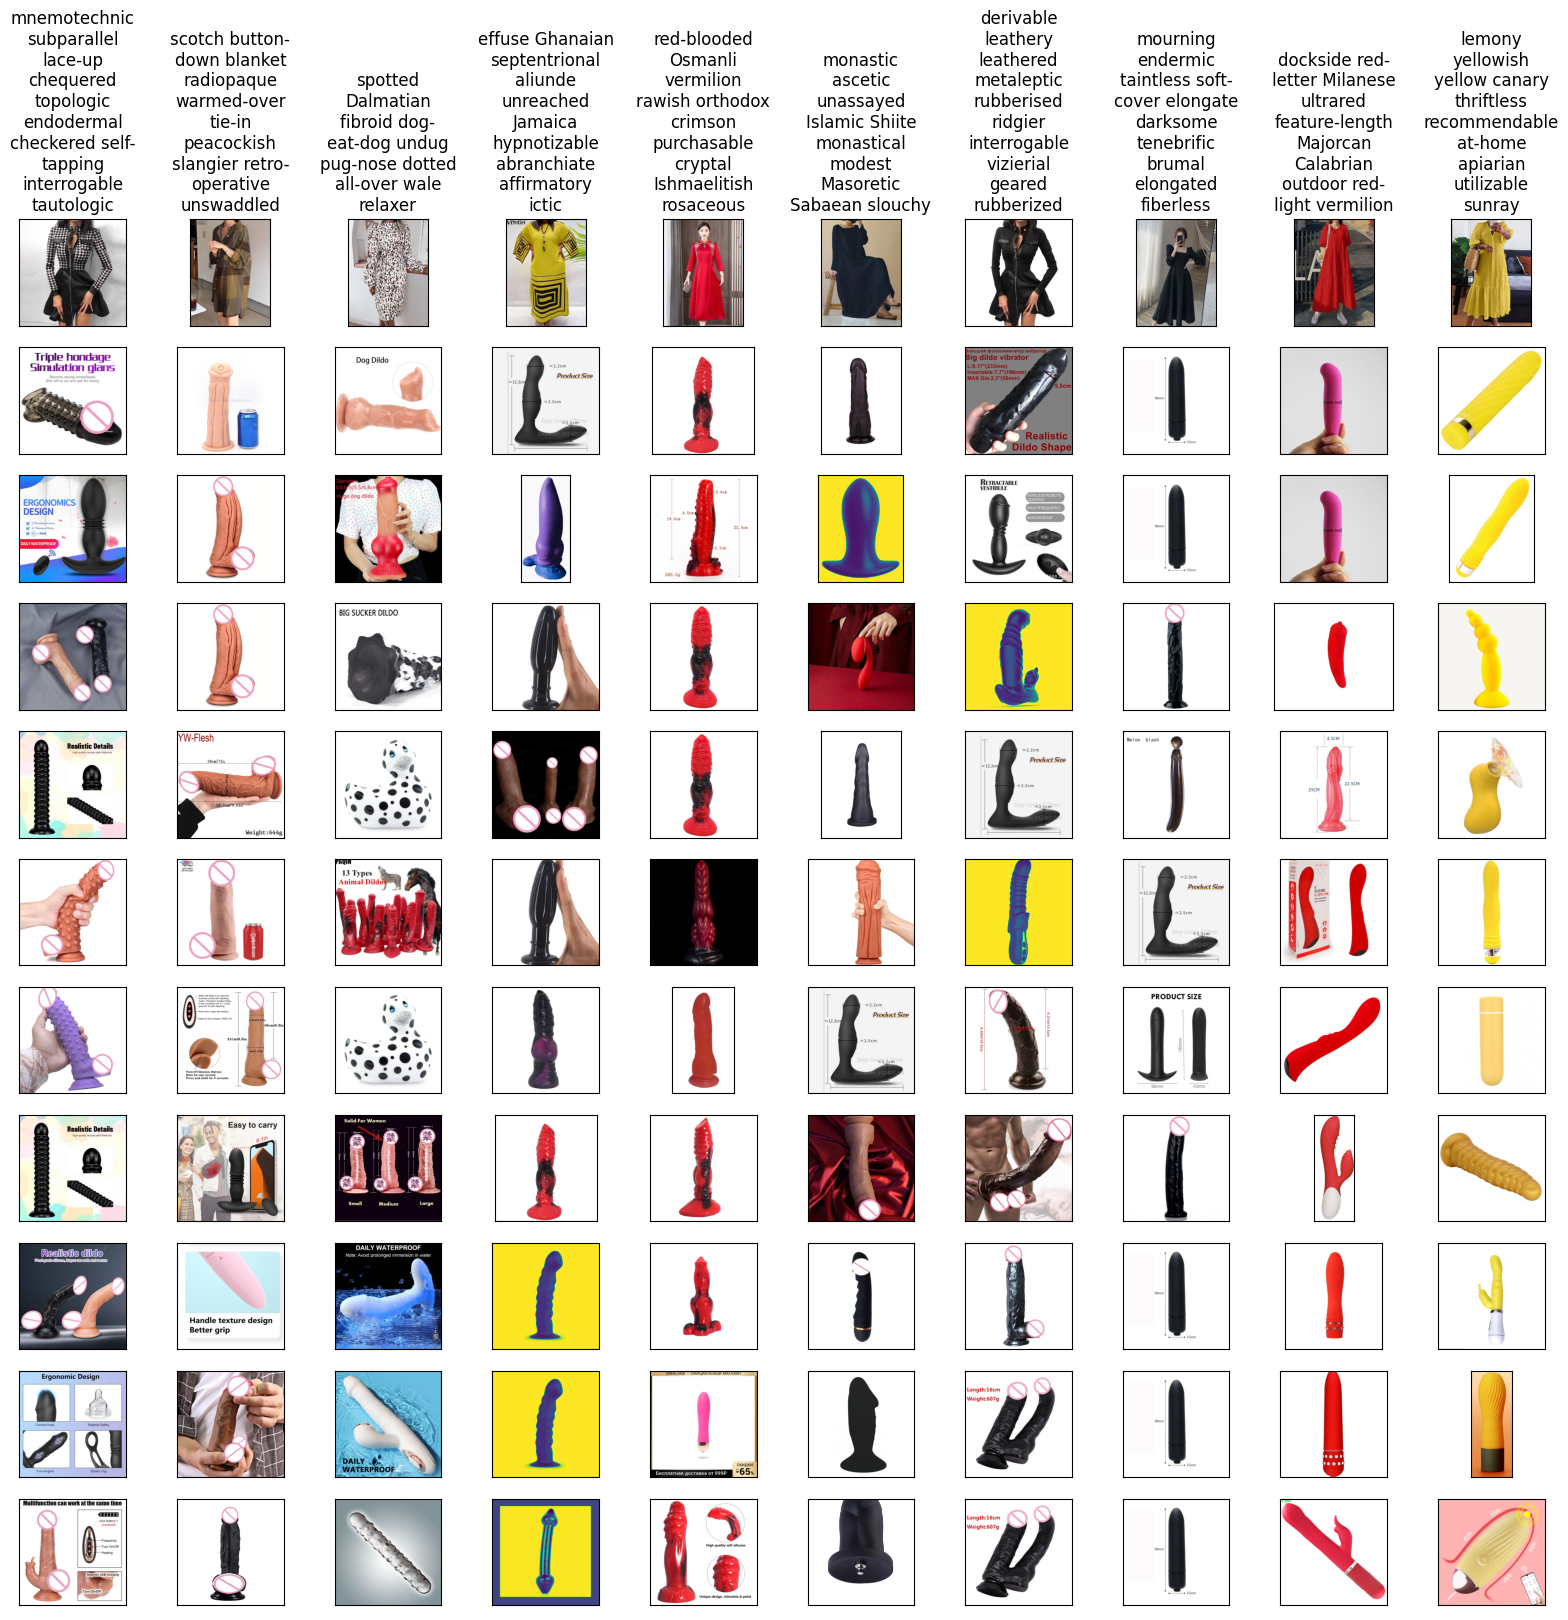

In [51]:
# Plot img to img version
import textwrap

fig, axes = plt.subplots(11, 10, figsize=(20, 18))
for query_idx, (prompt, doc_indices) in enumerate(zip(prompts, top_doc_img_indices)):
    ax = axes[0]
    ax[query_idx].imshow(Image.open(query_img_paths[query_idx]))
    prompt = '\n'.join(textwrap.wrap(prompt, width=15))
    ax[query_idx].set_title(prompt)
    ax[query_idx].set_xticks([])
    ax[query_idx].set_yticks([])
    for axi, doc_idx in enumerate(doc_indices):
        axes[axi + 1][query_idx].imshow(Image.open(doc_img_paths[doc_idx]))
        axes[axi + 1][query_idx].set_xticks([])
        axes[axi + 1][query_idx].set_yticks([])

In [ ]:
# txt to txt version
def get_similar_by_text_embs(
    query_img_embs,
    doc_img_embs,
    query_words_embs,  # for a single adjective
    doc_words_embs,  # for a single adjective
    texts,  # unified for both query/doc 
    topk_words=TOPK_WORDS, 
    topk_doc_imgs=TOPK_DOC_IMGS,
    query_prompt_template="a photo of a {} dress",
    doc_prompt_template="a photo of a {} dildo"
):
    # for each query emb get a string of top closest texts
    raw_query_prompts = embs_to_text_prompts(
        query_img_embs, 
        query_words_embs, 
        texts, 
        topk_words=topk_words
    )

    # get the embeddings of the acquired query prompts
    def query_prompt_preprocess(text):
        text = text.strip().lower()
        text = query_prompt_template.format(text)
        text = clip.tokenize(text)
        return text

    query_prompts_dataset = TextDataset(
        texts=raw_query_prompts,
        preprocess=query_prompt_preprocess
    )

    query_prompts_embs = get_txt_features(query_prompts_dataset)
    
    
    # for each doc emb get a string of top closest texts
    raw_doc_prompts = embs_to_text_prompts(
        doc_img_embs, 
        doc_words_embs, 
        texts, 
        topk_words=topk_words
    )

    # get the embeddings of the acquired doc prompts
    def doc_prompt_preprocess(text):
        text = text.strip().lower()
        text = doc_prompt_template.format(text)
        text = clip.tokenize(text)
        return text

    doc_prompts_dataset = TextDataset(
        texts=raw_doc_prompts,
        preprocess=doc_prompt_preprocess
    )

    doc_prompts_embs = get_txt_features(doc_prompts_dataset)
    
    
    # for each query prompt emb find closest doc prompt emb 
    # (similarity scores and indices)
    _, top_doc_img_indices = get_top_similar(
        query_prompts_embs,
        doc_prompts_embs,
        topk=TOPK_DOC_IMGS
    )
    
    return raw_query_prompts, top_doc_img_indices, raw_doc_prompts


raw_query_prompts, top_doc_img_indices, raw_doc_prompts = get_similar_by_text_embs(
    query_img_embs,
    doc_img_embs,
    query_words_embs=query_text_embs,  # for a single adjective
    doc_words_embs=doc_text_embs,  # for a single adjective
    texts=texts,  # unified for both query/doc 
)

doc_prompts_selected = []
for top_doc_idx_row in top_doc_img_indices:
    doc_prompts_selected.append([raw_doc_prompts[x] for x in top_doc_idx_row])

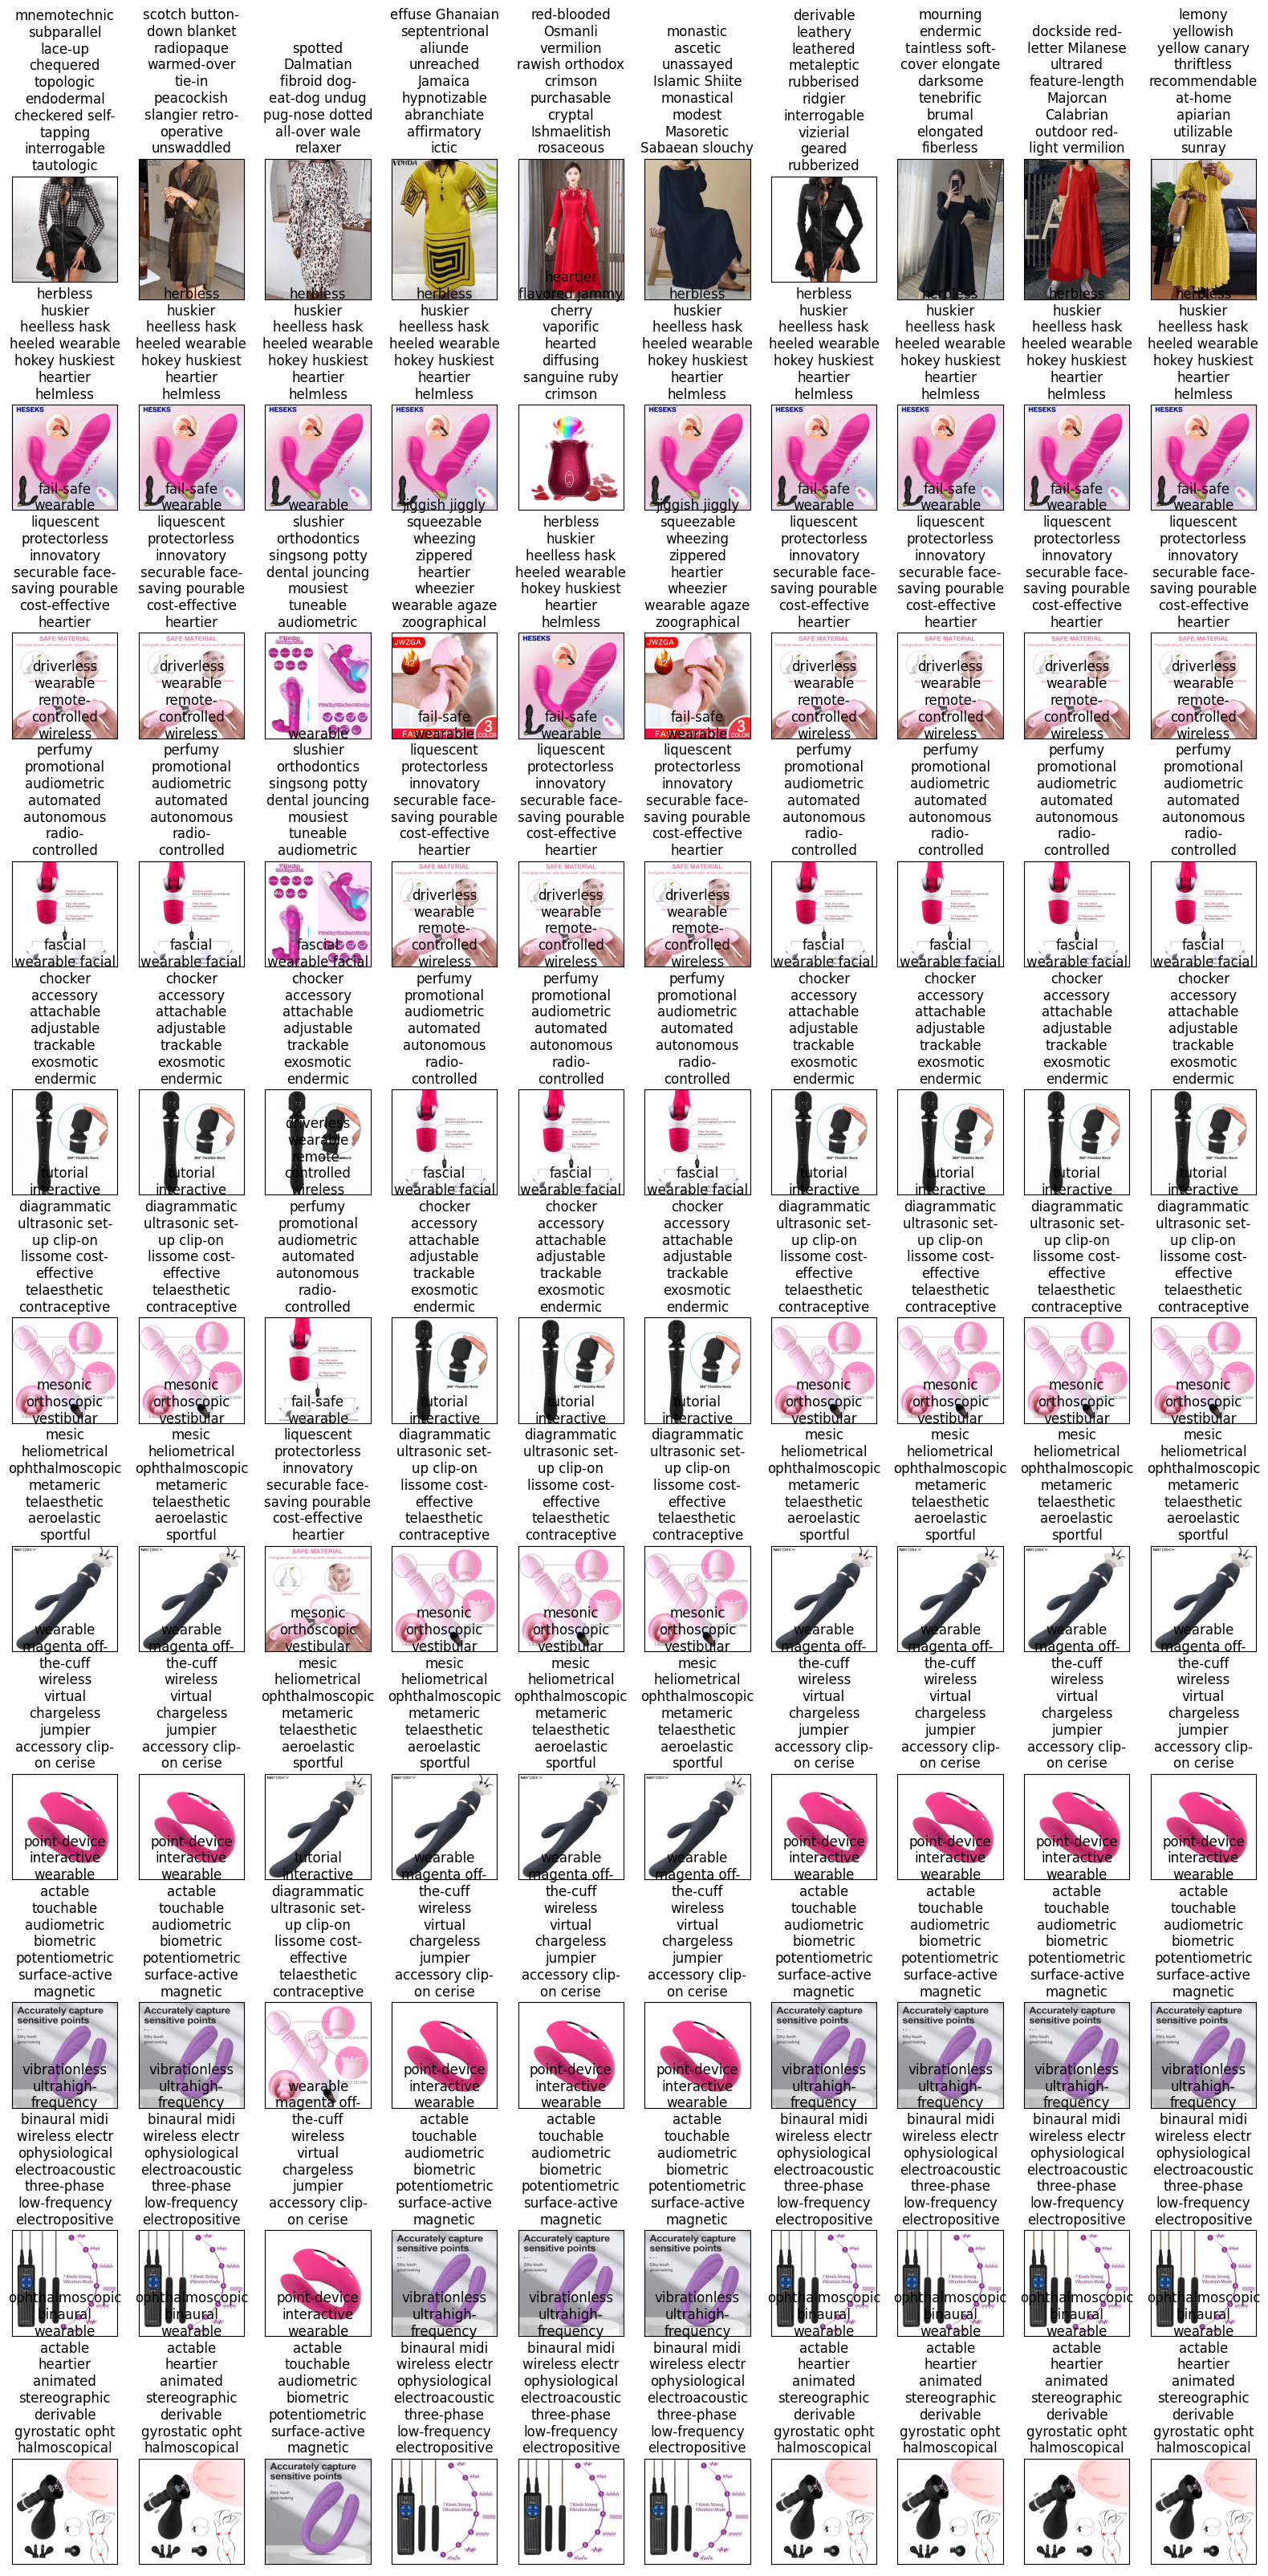

In [48]:
# plot txt to txt version
import textwrap

fig, axes = plt.subplots(11, 10, figsize=(20, 40))
for query_idx, (prompt, doc_indices) in enumerate(zip(raw_query_prompts, top_doc_img_indices)):
    ax = axes[0]
    ax[query_idx].imshow(Image.open(query_img_paths[query_idx]))
    prompt = '\n'.join(textwrap.wrap(prompt, width=15))
    ax[query_idx].set_title(prompt)
    ax[query_idx].set_xticks([])
    ax[query_idx].set_yticks([])
    doc_prompts = doc_prompts_selected[query_idx]
    for axi, (doc_idx, doc_prompt) in enumerate(zip(doc_indices, doc_prompts)):
        wrapped_prompt = '\n'.join(textwrap.wrap(doc_prompt, width=15))
        axes[axi + 1][query_idx].imshow(Image.open(doc_img_paths[doc_idx]))
        axes[axi + 1][query_idx].set_title(wrapped_prompt)
        axes[axi + 1][query_idx].set_xticks([])
        axes[axi + 1][query_idx].set_yticks([])